# Machine Learning with PySpark MLlib
%
PySpark MLlib is the Apache Spark scalable machine learning library in Python consisting of common learning algorithms and utilities. Throughout this latrackter, you'll learn important Machine Learning algorithms. You will build a movie recommendation engine and a spam filter, and use k-means clustering.

## Preparing the environment

### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql.types import (_parse_datatype_string, StructType, StructField,
                               DoubleType, IntegerType, StringType)
from pyspark.sql import SparkSession

# ml libraries
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.clustering import KMeans

# Collaborative filtering
from pyspark.mllib.recommendation import Rating

# Classification
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import HashingTF

# Clustering
from pyspark.mllib.clustering import KMeans
from math import sqrt

### Connect to Spark

In [2]:
spark = SparkSession.builder.getOrCreate()

# eval DataFrame in notebooks
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
sc = spark.sparkContext

### Reading the data

In [4]:
fifa = spark.read.csv('data-sources/Fifa2018_dataset.csv', header=True, inferSchema=True)
# cast to integer
for col_name in ['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure', 
                 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'GK diving', 
                 'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy', 
                 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties', 
                 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle', 
                 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys']:
    fifa = fifa.withColumn(col_name, fifa[col_name].cast('integer'))
fifa.createOrReplaceTempView("fifa")
fifa.printSchema()
fifa.limit(2)

root
 |-- _c0: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Acceleration: integer (nullable = true)
 |-- Aggression: integer (nullable = true)
 |-- Agility: integer (nullable = true)
 |-- Balance: integer (nullable = true)
 |-- Ball control: integer (nullable = true)
 |-- Composure: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Curve: integer (nullable = true)
 |-- Dribbling: integer (nullable = true)
 |-- Finishing: integer (nullable = true)
 |-- Free kick accuracy: integer (nullable = true)
 |-- GK diving: integer (nulla

_c0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofif...,Portugal,https://cdn.sofif...,94,94,Real Madrid CF,https://cdn.sofif...,€95.5M,€565K,2228,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,ST LW,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofif...,Argentina,https://cdn.sofif...,93,93,FC Barcelona,https://cdn.sofif...,€105M,€565K,2154,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,RW,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0


In [5]:
movies = spark.read.csv('data-sources/movie-ratings.csv', header=False, inferSchema=True,
                        schema='userId int, movieId int, rating double, timestamp int')
movies.createOrReplaceTempView("movies")
movies.printSchema()
movies.limit(2)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



userId,movieId,rating,timestamp
1,31,2.5,1260759144
1,1029,3.0,1260759179


In [6]:
people = spark.read.csv('data-sources/people.csv', header=True, inferSchema=True)
people.createOrReplaceTempView("people")
people.printSchema()
people.limit(2)

root
 |-- _c0: integer (nullable = true)
 |-- person_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- date of birth: timestamp (nullable = true)



_c0,person_id,name,sex,date of birth
0,100,Penelope Lewis,female,1990-08-31 00:00:00
1,101,David Anthony,male,1971-10-14 00:00:00


In [7]:
wine = spark.read.csv('data-sources/wine-data.csv', header=True, inferSchema=True)
wine.createOrReplaceTempView("wine")
wine.printSchema()
wine.limit(2)

root
 |-- Wine: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- Malic.acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Acl: double (nullable = true)
 |-- Mg: integer (nullable = true)
 |-- Phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- Nonflavanoid.phenols: double (nullable = true)
 |-- Proanth: double (nullable = true)
 |-- Color.int: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD: double (nullable = true)
 |-- Proline: integer (nullable = true)



Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050


In [8]:
spark.catalog.listTables()

[Table(name='fifa', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='movies', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='people', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='wine', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

## Ex. 1 - PySpark MLlib algorithms

Before using any Machine learning algorithms in PySpark shell, you'll have to import the submodules of pyspark.mllib library and then choose the appropriate class that is needed for a specific machine learning task.

In this simple exercise, you'll learn how to import the different submodules of pyspark.mllib along with the classes that are needed for performing Collaborative filtering, Classification, and Clustering algorithms.

**Instructions:**

1. Import `pyspark.mllib` recommendation submodule and Alternating Least Squares class.
2. Import `pyspark.mllib` classification submodule and Logistic Regression with LBFGS class.
3. Import `pyspark.mllib` clustering submodule and kmeans class.

In [9]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS

# Import the library for Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

## Collaborative filtering

### Rating class in pyspark.mllib.recommendation submodule

In [10]:
r = Rating(user = 1, product = 2, rating = 5.0)
print((r[0], r[1], r[2]))
r

(1, 2, 5.0)


Rating(user=1, product=2, rating=5.0)

### Splitting the data using randomSplit()

In [11]:
data = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

training, test = data.randomSplit([0.6, 0.4], seed=42)

print(training.collect())
print(test.collect())

[1, 4, 5, 7, 8, 9, 10]
[2, 3, 6]


### Alternating Least Squares (ALS)

- Alternating Least Squares (ALS) algorithm in `spark.mllib` provides collaborative filtering
- ALS.train(ratings, rank, iterations)

In [12]:
r1 = Rating(1, 1, 1.0)
r2 = Rating(1, 2, 2.0)
r3 = Rating(2, 1, 2.0)

ratings = sc.parallelize([r1, r2, r3])
ratings.collect()

[Rating(user=1, product=1, rating=1.0),
 Rating(user=1, product=2, rating=2.0),
 Rating(user=2, product=1, rating=2.0)]

In [13]:
model = ALS.train(ratings, rank=10, iterations=10)
model

### predictAll()

- The `predictAll()` method returns a list of predicted ratings for input user and product pair
- The method takes in a RDD without ratings to generate the ratings

In [14]:
unrated_RDD = sc.parallelize([(1, 2), (1, 1)])

predictions = model.predictAll(unrated_RDD)
predictions.collect()

[Rating(user=1, product=1, rating=1.000018109412695),
 Rating(user=1, product=2, rating=1.9890386220695941)]

### Model evaluation

The MSE is the average value of the square of (actual rating - predicted rating)

In [15]:
ratings.collect()

[Rating(user=1, product=1, rating=1.0),
 Rating(user=1, product=2, rating=2.0),
 Rating(user=2, product=1, rating=2.0)]

In [16]:
rates = ratings.map(lambda x: ((x[0], x[1]), x[2]))
rates.collect()

[((1, 1), 1.0), ((1, 2), 2.0), ((2, 1), 2.0)]

In [17]:
preds = predictions.map(lambda x: ((x[0], x[1]), x[2]))
preds.collect()

[((1, 1), 1.000018109412695), ((1, 2), 1.9890386220695941)]

In [18]:
rates_preds = rates.join(preds)
rates_preds.collect()

[((1, 2), (2.0, 1.9890386220695941)), ((1, 1), (1.0, 1.000018109412695))]

In [19]:
MSE = rates_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
MSE

6.0076067042008384e-05

## Ex. 2 - Loading Movie Lens dataset into RDDs

Collaborative filtering is a technique for recommender systems wherein users' ratings and interactions with various products are used to recommend new ones. With the advent of Machine Learning and parallelized processing of data, recommender systems have become widely popular in recent years, and are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags. In this 3-part exercise, your goal is to develop a simple movie recommendation system using PySpark MLlib using a subset of [MovieLens 100k dataset](data-sources/movie-ratings.csv).

In the first part, you'll first load the MovieLens data (`movie-ratings.csv`) into RDD and from each line in the RDD which is formatted as `userId,movieId,rating,timestamp`, you'll need to map the `MovieLens` data to a `Ratings` object (`userID, productID, rating`) after removing `timestamp` column and finally you'll split the RDD into `training` and `test` RDDs.

**Instructions:**

1. Load the `movie-ratings.csv` dataset into an RDD.
2. Split the RDD using `,` as a delimiter.
3. For each line of the RDD, using `Rating()` class create a tuple of `userID, productID, rating`.
4. Randomly split the data into training data and test data (0.8 and 0.2).

### First method, reading data as RDD

In [20]:
# Load the data into RDD
file_path = 'data-sources/movie-ratings.csv'
data = sc.textFile(file_path)
data.take(5)

['1,31,2.5,1260759144',
 '1,1029,3.0,1260759179',
 '1,1061,3.0,1260759182',
 '1,1129,2.0,1260759185',
 '1,1172,4.0,1260759205']

In [21]:
# Split the RDD 
ratings = data.map(lambda l: l.split(','))
ratings.take(5)

[['1', '31', '2.5', '1260759144'],
 ['1', '1029', '3.0', '1260759179'],
 ['1', '1061', '3.0', '1260759182'],
 ['1', '1129', '2.0', '1260759185'],
 ['1', '1172', '4.0', '1260759205']]

In [22]:
# Transform the ratings RDD 
ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))
ratings_final.take(5)

[Rating(user=1, product=31, rating=2.5),
 Rating(user=1, product=1029, rating=3.0),
 Rating(user=1, product=1061, rating=3.0),
 Rating(user=1, product=1129, rating=2.0),
 Rating(user=1, product=1172, rating=4.0)]

In [23]:
# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])
print(f'''
Data: {ratings_final.count()} rows
Training set: {training_data.count()} rows
Test set: {test_data.count()} rows
''')


Data: 100004 rows
Training set: 79764 rows
Test set: 20240 rows



### Second method, reading data as Spark Dataframe 

Data has been already read as Spark Dataframe and saved in `movies`.

In [24]:
data2 = movies.rdd
data2.take(5)

[Row(userId=1, movieId=31, rating=2.5, timestamp=1260759144),
 Row(userId=1, movieId=1029, rating=3.0, timestamp=1260759179),
 Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182),
 Row(userId=1, movieId=1129, rating=2.0, timestamp=1260759185),
 Row(userId=1, movieId=1172, rating=4.0, timestamp=1260759205)]

In [25]:
# Transform to the ratings RDD 
ratings_final2 = data2.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))
ratings_final2.take(5)

[Rating(user=1, product=31, rating=2.5),
 Rating(user=1, product=1029, rating=3.0),
 Rating(user=1, product=1061, rating=3.0),
 Rating(user=1, product=1129, rating=2.0),
 Rating(user=1, product=1172, rating=4.0)]

In [26]:
# Split the data into training and test
training_data2, test_data2 = ratings_final2.randomSplit([0.8, 0.2])

print(f'''
Data: {ratings_final2.count()} rows
Training set: {training_data2.count()} rows
Test set: {test_data2.count()} rows
''')


Data: 100004 rows
Training set: 80188 rows
Test set: 19816 rows



## Ex. 3 - Model training and predictions

After splitting the data into training and test data, in the second part of the exercise, you'll train the ALS algorithm using the training data. PySpark MLlib's ALS algorithm has the following mandatory parameters - `rank` (the number of latent factors in the model) and `iterations` (number of iterations to run). After training the ALS model, you can use the model to predict the ratings from the test data. For this, you will provide the user and item columns from the test dataset and finally return the list of 2 rows of `predictAll()` output.

**Instructions:**

- Train ALS algorithm with training data and configured parameters (`rank = 10` and `iterations = 10`).
- Drop the `rating` column in the test data, which is the third column.
- Test the model by predicting the rating from the test data.
- Return a list of two rows of the predicted ratings.

In [27]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)
model

In [28]:
test_data.take(3)

[Rating(user=1, product=1029, rating=3.0),
 Rating(user=1, product=1263, rating=2.0),
 Rating(user=1, product=1339, rating=3.5)]

In [29]:
# Drop the ratings column 
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))
testdata_no_rating.take(3)

[(1, 1029), (1, 1263), (1, 1339)]

In [30]:
# Predict the model  
predictions = model.predictAll(testdata_no_rating)

# Return the first 2 rows of the RDD
predictions.take(3)

[Rating(user=529, product=3456, rating=3.0211005805447053),
 Rating(user=564, product=320, rating=3.8249473171938817),
 Rating(user=165, product=1840, rating=3.2364912921670363)]

## Ex. 4 - Model evaluation using MSE

After generating the predicted ratings from the test data using ALS model, in this final part of the exercise, you'll prepare the data for calculating Mean Square Error (MSE) of the model. The MSE is the average value of (original rating – predicted rating)**2 for all users and indicates the absolute fit of the model to the data.

To do this, first, you'll organize both the ratings_final and predictions RDDs to make a tuple of `((user, product), rating))`. In both RDDs the mapping is:
```
0: user
1: product
2: rating
```

Then you'll join transformed RDDs and finally apply a squared difference function along with `mean()` to get the MSE.

**Instructions:**

- Organize `ratings` RDD to make `((user, product), rating)`.
- Organize `predictions` RDD to make `((user, product), rating)`.
- Join the `prediction` RDD with the `ratings` RDD.
- Evaluate the model using MSE between original rating and predicted rating and print it.

In [31]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))
rates.take(3)

[((1, 31), 2.5), ((1, 1029), 3.0), ((1, 1061), 3.0)]

In [32]:
# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))
preds.take(3)

[((529, 3456), 3.0211005805447053),
 ((564, 320), 3.8249473171938817),
 ((165, 1840), 3.2364912921670363)]

In [33]:
# Join the ratings data with predictions data
rates_and_preds = rates.join(preds)
rates_and_preds.take(3)

[((1, 1029), (3.0, 0.8428742394249458)),
 ((4, 1032), (5.0, 4.715217655384938)),
 ((4, 1210), (5.0, 4.805024029427819))]

In [34]:
# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.34


## Classification

### Working with Vectors

- PySpark MLlib contains specific data types Vectors and LabeledPoint
- Two types of Vectors
    - Dense Vector: store all their entries in an array of floating point numbers
    - Sparse Vector: store only the nonzero values and their indices

In [35]:
denseVec = Vectors.dense([1.0, None, 2.0, 3.0])
denseVec

DenseVector([1.0, nan, 2.0, 3.0])

In [36]:
sparseVec = Vectors.sparse(4, {1: 1.0, 3: 5.5})
sparseVec

SparseVector(4, {1: 1.0, 3: 5.5})

### LabeledPoint() in PySpark MLlib

- A LabeledPoint is a wrapper for input features and predicted value
- For binary classification of Logistic Regression, a label is either `0` (negative) or `1` (positive)

In [37]:
positive = LabeledPoint(1.0, [1.0, 0.0, 3.0])
negative = LabeledPoint(0.0, [2.0, 1.0, 1.0])

print(positive)
print(negative)

(1.0,[1.0,0.0,3.0])
(0.0,[2.0,1.0,1.0])


In [38]:
positive.label, positive.features

(1.0, DenseVector([1.0, 0.0, 3.0]))

### HashingTF() in PySpark MLlib

- `HashingTF()` algorithm is used to map feature value to indices in the feature vector

In [39]:
sentence = "hello hello world"
words = sentence.split()

tf = HashingTF(10000)
tf.transform(words)

SparseVector(10000, {3544: 1.0, 9079: 2.0})

### Logistic Regression using LogisticRegressionWithLBFGS
- 
Logistic Regression using Pyspark MLlib is achieved using` LogisticRegressionWithLBFG` 
class

In [40]:
# Loading the data
data = [
    LabeledPoint(0.0, [0.0, 1.0]),
    LabeledPoint(1.0, [1.0, 0.0]),
]

RDD = sc.parallelize(data)
RDD.collect()

[LabeledPoint(0.0, [0.0,1.0]), LabeledPoint(1.0, [1.0,0.0])]

In [41]:
# Setting the model
lrm = LogisticRegressionWithLBFGS.train(RDD)
lrm

pyspark.mllib.LogisticRegressionModel: intercept = 0.0, numFeatures = 2, numClasses = 2, threshold = 0.5

In [42]:
# Making predictions
(lrm.predict([1.0, 0.0]), lrm.predict([0.0, 1.0]))

(1, 0)

## Ex. 5 - Loading spam and non-spam data

Logistic Regression is a popular method to predict a categorical response. Probably one of the most common applications of the logistic regression is the message or email spam classification. In this 3-part exercise, you'll create an email spam classifier with logistic regression using Spark MLlib. Here are the brief steps for creating a spam classifier.

- Create an RDD of strings representing email.
- Run MLlib’s feature extraction algorithms to convert text into an RDD of vectors.
- Call a classification algorithm on the RDD of vectors to return a model object to classify new points.
- Evaluate the model on a test dataset using one of MLlib’s evaluation functions.

In the first part of the exercise, you'll load the `'spam'` and `'ham'` (non-spam) files into RDDs, split the emails into individual words, and look at the first element in each of the RDD.

**Instructions:**

1. Create two RDDS, one for `'spam'` and one for `'non-spam (ham)'`.
2. Split each email in `'spam'` and `'non-spam'` RDDs into words.
3. Print the first element in the split RDD of both `'spam'` and `'non-spam'`.

In [43]:
file_path_spam = "data-sources/spam.txt"
file_path_non_spam = "data-sources/ham.txt"

# Load the datasets into RDDs
spam_rdd = sc.textFile(file_path_spam)
non_spam_rdd = sc.textFile(file_path_non_spam)

# Reviewing the data
print(f'''
Spam: {spam_rdd.count()} lines
First line: {spam_rdd.first()}

Non Spam: {non_spam_rdd.count()} lines
First line: {non_spam_rdd.first()}
''')


Spam: 747 lines
First line: You have 1 new message. Please call 08712400200.

Non Spam: 4827 lines
First line: Rofl. Its true to its name



In [44]:
# Split the email messages into words
spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

# Reviewing the data
print(f'''
Spam: {spam_words.count()} words
First 2 item: {spam_words.take(2)}

Non Spam: {non_spam_words.count()} words
First 2 item: {non_spam_words.take(2)}
''')


Spam: 17893 words
First 2 item: ['You', 'have']

Non Spam: 69642 words
First 2 item: ['Rofl.', 'Its']



In [45]:
# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


## Ex. 6 - Feature hashing and LabelPoint

After splitting the emails into words, our raw data sets `'spam'` and `'non-spam'` are currently composed of 1-line messages. In order to classify these messages, we need to convert text into features.

In the second part of the exercise, you'll first create a `HashingTF()` instance to map text to vectors of 200 features. Then for each message in `'spam'` and `'non-spam'` files you'll split them into words, and map each word to one feature. These are the features that will be used to decide whether a message is `'spam'` or `'non-spam'`. Next, you'll create labels for features. For a valid message, the label will be 0 (i.e. the message is not spam) and for a 'spam' message, the label will be 1 (i.e. the message is spam). Finally, you'll combine both labeled datasets.

**Instructions:**

1. Create a `HashingTF()` instance to map email text to vectors of 200 features.
2. Each message in 'spam' and 'non-spam' datasets are split into words, and each word is mapped to one feature.
3. Label the features: 1 for spam, 0 for non-spam.
4. Combine both the spam and non-spam samples into a single dataset.

In [46]:
# Create a HashingTF instance with 200 features
tf = HashingTF(numFeatures=200)

In [47]:
# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

spam_features.take(3)

[SparseVector(200, {75: 1.0, 150: 1.0, 183: 1.0}),
 SparseVector(200, {1: 1.0, 19: 1.0, 165: 1.0, 169: 1.0}),
 SparseVector(200, {197: 1.0})]

In [48]:
# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features: LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features: LabeledPoint(0, features))

spam_samples.take(3)

[LabeledPoint(1.0, (200,[75,150,183],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,165,169],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[197],[1.0]))]

In [49]:
# Combine the two datasets
samples = spam_samples.union(non_spam_samples)
samples.take(2)

[LabeledPoint(1.0, (200,[75,150,183],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,19,165,169],[1.0,1.0,1.0,1.0]))]

## Ex. 7 - Logistic Regression model training

After creating labels and features for the data, we’re ready to build a model that can learn from it (training). But before you train the model, in this final part of the exercise, you'll split the data into training and test, run Logistic Regression model on the training data, and finally check the accuracy of the model trained on training data.

**Instructions:**

1. Split the combined data into training and test datasets in 80:20 ratio.
2. Train the Logistic Regression model with the training dataset.
3. Create a prediction label from the trained model on the test dataset.
4. Combine the labels in the test dataset with the labels in the prediction dataset using `zip` function.
5. Calculate the accuracy of the trained model using original and predicted labels, and print it.

In [50]:
# Split the data into training and testing
train_samples, test_samples = samples.randomSplit([0.8, 0.2])

print(f'''
Data: {samples.count()} rows
Training set: {train_samples.count()} rows
Test set: {test_samples.count()} rows
''')


Data: 87535 rows
Training set: 69888 rows
Test set: 17647 rows



In [51]:
# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))
predictions.take(10)

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

In [52]:
# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)
labels_and_preds.take(10)

[(1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 1),
 (1.0, 1),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0)]

In [53]:
# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

Model accuracy : 0.82


## Clustering

### K-means with Spark MLLib

- K-means is the most popular clustering method

In [54]:
RDD = wine.rdd.map(lambda x: [x[1], x[2]])
RDD.take(5)

[[14.23, 1.71], [13.2, 1.78], [13.16, 2.36], [14.37, 1.95], [13.24, 2.59]]

### Train a K-means clustering model

- Training K-means model is done using KMeans.train() method

In [55]:
model = KMeans.train(RDD, k = 3, maxIterations = 10)
model.clusterCenters

[array([13.705     ,  1.78606061]),
 array([13.0632,  3.8948]),
 array([12.20032258,  1.66532258])]

### Evaluating the K-means Model

In [56]:
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = RDD.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 112.44077382105796


### Visualizing clusters

In [57]:
col_names = ["Alcohol", "Malic"]

wine_data_df = spark.createDataFrame(RDD, schema=col_names)
wine_data_df_pandas = wine_data_df.toPandas()
wine_data_df_pandas.head()

,Alcohol,Malic
0,14.23,1.71
1,13.20,1.78
2,13.16,2.36
3,14.37,1.95
4,13.24,2.59


In [58]:
cluster_centers_pandas = pd.DataFrame(model.clusterCenters, columns=col_names)
cluster_centers_pandas.head()

,Alcohol,Malic
0,13.705000,1.786061
1,13.063200,3.894800
2,12.200323,1.665323


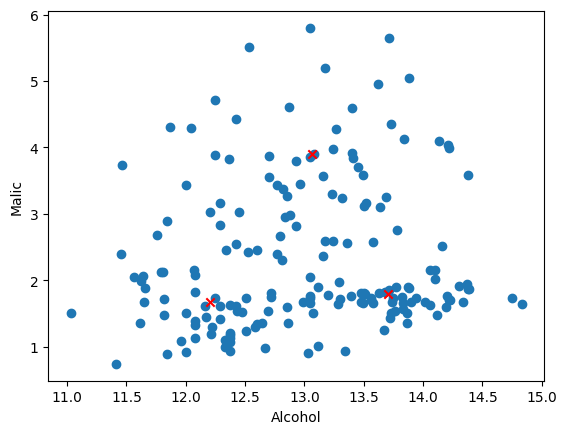

In [59]:
plt.scatter(wine_data_df_pandas[col_names[0]], wine_data_df_pandas[col_names[1]]);
plt.scatter(cluster_centers_pandas[col_names[0]], cluster_centers_pandas[col_names[1]],
            color="red", marker="x")
plt.xlabel(col_names[0])
plt.ylabel(col_names[1])
plt.show()

## Ex. 8 - Loading and parsing the 5000 points data

Clustering is the unsupervised learning task that involves grouping objects into clusters of high similarity. Unlike the supervised tasks, where data is labeled, clustering can be used to make sense of unlabeled data. PySpark MLlib includes the popular K-means algorithm for clustering. In this 3 part exercise, you'll find out how many clusters are there in a dataset containing 5000 rows and 2 columns. For this you'll first load the data into an RDD, parse the RDD based on the delimiter, run the KMeans model, evaluate the model and finally visualize the clusters.

In the first part, you'll load the data into RDD, parse the RDD based on the delimiter, and convert the string type of the data to an integer.

**Instructions:**

1. Load the `5000_points` dataset into an RDD named `clusterRDD`.
2. Transform the `clusterRDD` by splitting the lines based on the tab (`"\t"`).
3. Transform the split RDD to create a list of integers for the two columns.
4. Confirm that there are 5000 rows in the dataset.

In [60]:
# Load the dataset into an RDD
file_path = "data-sources/5000_points.txt"
clusterRDD = sc.textFile(file_path)

# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split("\t"))

# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

# Count the number of rows in RDD 
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


In [61]:
rdd_split_int.take(5)

[[664159, 550946],
 [665845, 557965],
 [597173, 575538],
 [618600, 551446],
 [635690, 608046]]

## Ex. 9 - K-means training

Now that the RDD is ready for training, in this 2nd part, you'll test it with k's from 13 to 16 (to save computation time) and use the elbow method to chose the correct `k`. The idea of the elbow method is to run K-means clustering on the dataset for different values of `k`, calculate Within Set Sum of Squared Error (WSSSE), and select the best `k` based on the sudden drop in WSSSE, i.e. where the elbow occurs. Next, you'll retrain the model with the best `k` and finally, get the centroids (cluster centers).

**Instructions:**

1. Train the KMeans model with clusters from 13 to 16 and print the WSSSE for each cluster.
2. Train the KMeans model again with the best k.
3. Get the Cluster Centers (centroids) of KMeans model trained with the best k.

In [62]:
# Train the model with clusters from 13 to 16 and compute WSSSE
k_list = list(range(13, 17))
WSSSE_list = []
for clst in k_list:
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    WSSSE_list.append(WSSSE)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))

The cluster 13 has Within Set Sum of Squared Error 252060331.1260039
The cluster 14 has Within Set Sum of Squared Error 215808893.2796594
The cluster 15 has Within Set Sum of Squared Error 169394691.52639425
The cluster 16 has Within Set Sum of Squared Error 168103213.0429197


In [63]:
diff = [WSSSE_list[x] - WSSSE_list[x+1] for x in range(len(WSSSE_list) - 1)]
print(diff)  # Calculated drop in Sum of Squared Error for eack tested k
# For k [14, 15, 16], for k=13 the drop is 0

[36251437.8463445, 46414201.75326514, 1291478.4834745526]


In [64]:
best_k = k_list[diff.index(max(diff))+1]
best_k

15

In [65]:
# Train the model again with the best k
model = KMeans.train(rdd_split_int, k=best_k, seed=1)

# Get cluster centers
cluster_centers = model.clusterCenters
cluster_centers

[array([417799.69426752, 787001.99363057]),
 array([852058.45259939, 157685.52293578]),
 array([858947.9713467 , 546259.65902579]),
 array([398555.94857143, 404855.06857143]),
 array([507818.31339031, 175610.41595442]),
 array([167856.14071856, 347812.71556886]),
 array([337565.11890244, 562157.17682927]),
 array([139682.37572254, 558123.40462428]),
 array([320602.55, 161521.85]),
 array([244654.8856305 , 847642.04105572]),
 array([801616.78164557, 321123.34177215]),
 array([606574.95622896, 574455.16835017]),
 array([823421.2507837 , 731145.27272727]),
 array([617601.91071429, 399504.21428571]),
 array([670929.06818182, 862765.73295455])]

## Ex. 10 - Visualizing clusters

You just trained the k-means model with an optimum `k` value (`k=15`) and generated cluster centers (centroids). In this final exercise, you will visualize the clusters and the centroids by overlaying them. This will indicate how well the clustering worked (ideally, the clusters should be distinct from each other and centroids should be at the center of their respective clusters).

To achieve this, you will first convert the `rdd_split_int RDD` into a Spark DataFrame, and then into Pandas DataFrame which can be used for plotting. Similarly, you will convert cluster_centers into a Pandas DataFrame. Once both the DataFrames are created, you will create scatter plots using Matplotlib.

**Instructions:**

- Convert the `rdd_split_int` RDD to a Spark DataFrame, then to a pandas DataFrame.
- Create a pandas DataFrame from the `cluster_centers` list.
- Create a scatter plot from the pandas DataFrame of raw data (`rdd_split_int_df_pandas`) and overlay that with a scatter plot from the Pandas DataFrame of centroids (`cluster_centers_pandas`).

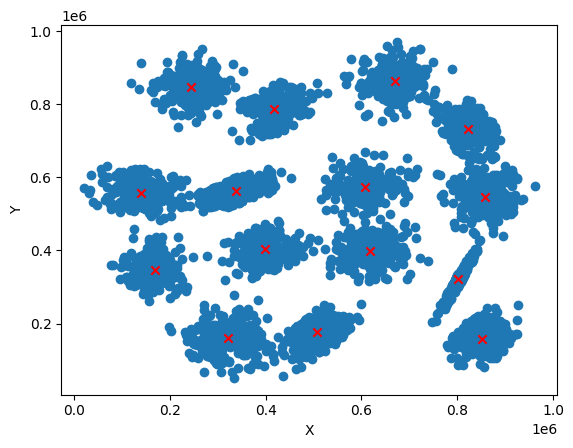

In [66]:
# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
col_names = ["X", "Y"]
rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int, schema=col_names).toPandas()

# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=col_names)

# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas[col_names[0]], rdd_split_int_df_pandas[col_names[1]])
plt.scatter(cluster_centers_pandas[col_names[0]], cluster_centers_pandas[col_names[1]], 
            color="red", marker="x")
plt.xlabel(col_names[0])
plt.ylabel(col_names[1])
plt.show()

## Close

In [67]:
spark.stop()